In [190]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams['figure.figsize'] = (16,9)

In [217]:
import data_helper as dh

In [232]:
reload(dh)
# reload(tf)

<module 'data_helper' from 'data_helper.py'>

# Bring in the data

In [233]:
semeval_train, semeval_valid = dh.load_semeval_data()
label2int = dh.label2int
int2label = {v:k for (k,v) in label2int.items()}

In [234]:
# create a vocab and dependency vocab
vocab_size = 100000
(vocab, vocab2int, int2vocab, vocab_dist) = (dh.create_vocab_from_data(
                                                  [datum[0] for datum in (semeval_train['x']+semeval_valid['x'])],
                                                  vocab_limit=vocab_size,
                                                  filter_oov=False))
# assert len(vocab) == vocab_size, "We don't have enough embeddings for those"
vocab_set = set(vocab)
print("Vocab size: %i" % len(vocab_set))
(dep_vocab, dep2int, int2dep, dep_dist) = (dh.create_vocab_from_data(
                                                  [datum[0] for datum in (semeval_train['x']+semeval_valid['x'])],
                                                  vocab_limit=50,
                                                  filter_oov=False,
                                                  dep=True))
dep_set = set(dep_vocab)
print("Dependency vocab size: %i" %len(dep_set))

Vocab size: 19300
Dependency vocab size: 45


In [235]:
print(semeval_train['x'][0][0])

the system as described above has its greatest application in an arrayed configuration of antenna elements


In [236]:
print("Before OOV: %i training sentences and %i validation" % (len(semeval_train['x']), len(semeval_valid['x'])))
semeval_train['x'], semeval_train['y'] = zip(*[ (datum, label) for (datum, label) 
                                                in zip(semeval_train['x'], semeval_train['y'])
                                                if not dh.is_oov(datum[0], vocab_set)])
semeval_valid['x'], semeval_valid['y'] = zip(*[ (datum, label) for (datum, label) 
                                                in zip(semeval_valid['x'], semeval_valid['y'])
                                                if not dh.is_oov(datum[0], vocab_set)])
print("After OOV: %i training sentences and %i validation" % (len(semeval_train['x']), len(semeval_valid['x'])))

Before OOV: 7109 training sentences and 891 validation
After OOV: 7109 training sentences and 891 validation


In [245]:
train_x, train_y = dh.convert_semeval_to_sdps(semeval_train['x'], semeval_train['y'], 
                                           vocab2int, dep2int,
                                           int2label, label2int, int2vocab,
                                           include_reverse=False,
                                           print_check=False)
valid_x, valid_y = dh.convert_semeval_to_sdps(semeval_valid['x'], semeval_valid['y'], 
                                           vocab2int, dep2int,
                                           int2label, label2int, int2vocab,
                                           include_reverse=False, 
                                           print_check=True)
print("\nAfter SDP conversion: %i training sentences and %i validation" 
      % (len(train_x), len(valid_x)))

ERROR: This sentence has no common dependency ancestor.  It was probably parsed incorrectly. SKIPPING
the doctor implanted an injection into three vertical glabellar furrows
[the , doctor , implanted , an , injection , into , three , vertical , glabellar , furrows]
4 9 [injection , implanted ] [furrows]
ERROR: This sentence has no common dependency ancestor.  It was probably parsed incorrectly. SKIPPING
this speed bag plaform is made of heavy duty powder coated steel that secures easily to a wood stud, brick or concrete
[this , speed , bag , plaform , is , made , of , heavy , duty , powder , coated , steel , that , secures , easily , to , a , wood , stud, , , brick , or , concrete]
3 11 [plaform , made ] [steel ]
the lawnmower cuts a swath of grass as it moves across the lawn
[the , lawnmower , cuts , a , swath , of , grass , as , it , moves , across , the , lawn] (1, 4)
[u'lawnmower', u'cuts', u'swath']
[6644, 2225, 18642]
cuts 
[6644, 2225], [u'lawnmower', u'cuts']
[18642], [u'swath'

In [246]:
# quick taste of data:
print(train_x[0], train_y[0])

[3352, 1, 2151] 0


In [247]:
max_sequence_len = max([len(x) for x in (train_x+valid_x)])
print("Max Sequence Length: %i" % max_sequence_len)

Max Sequence Length: 13


# Model

In [339]:
class RNN_Embed(object):
    """ Encapsulation of the dependency RNN lang model
    
    Largely inspired by https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/ptb_word_lm.py
    """
    def __init__(self, config):
#         self.batch_size = config['batch_size']
        self.max_num_steps = config['max_num_steps']
        self.word_embed_size = config['word_embed_size']
        self.hidden_size = config['hidden_size']
        self.max_grad_norm = config['max_grad_norm']
        self.vocab_dist = config['vocab_dist']
        self.vocab_size = len(self.vocab_dist)
#         self.nce_num_samples = config['nce_num_samples']
        self.name = config['model_name']
        self.checkpoint_prefix = config['checkpoint_prefix'] + self.name
        self.summary_prefix = config['summary_prefix'] + self.name
        
        self.initializer = tf.random_uniform_initializer(-1., 1.)
        
        with tf.name_scope("Forward"):
            self._build_forward_graph()
        with tf.name_scope("Backward"):
            self._build_train_graph()
        with tf.name_scope("Nearby"):
            self._build_similarity_graph()
        
        self.saver = tf.train.Saver(tf.all_variables())
        self._valid_accuracy = tf.Variable(0.0, trainable=False)
        self._valid_acc_summary = tf.merge_summary([tf.scalar_summary("Valid_accuracy", self._valid_accuracy)])
            
        self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())        
        self.summary_writer = tf.train.SummaryWriter(self.summary_prefix, self.session.graph_def)
        
    def save_validation_accuracy(self, new_score):
        assign_op = self._valid_accuracy.assign(new_score)
        _, summary = self.session.run([assign_op, self._valid_acc_summary])
        self.summary_writer.add_summary(summary)
        
    def _build_forward_graph(self):
        # input tensor of zero padded indices to get to max_num_steps
        # None allows for variable batch sizes
        with tf.name_scope("Inputs"):
            self._input_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps]) # [batch_size, w_{1:N}]
            self._input_targets = tf.placeholder(tf.int32, [None, 1]) # [batch_size, w_x]
            self._input_labels = tf.placeholder(tf.int32, [None, 1]) # [batch_size, from true data?] \in {0,1}
            self._input_lengths = tf.placeholder(tf.int32, [None, 1]) # [batch_size, N] (len of each sequence)
            batch_size = tf.shape(self._input_lengths)[0]
        
        with tf.name_scope("Word_Embeddings"):
            self._word_embeddings = tf.get_variable("word_embeddings", 
                                                    [self.vocab_size, self.word_embed_size],
                                                    dtype=tf.float32)
            # TODO: Add dependency embeddings
            # TODO: Add POS embeddings
            
            input_embeds = tf.nn.embedding_lookup(self._word_embeddings, self._input_phrases)
            target_embeds = tf.nn.embedding_lookup(self._word_embeddings, self._input_targets)
            # TODO: Add dropout to embeddings
        
        with tf.name_scope("RNN"):
            # start off with a basic configuration
            self.cell = tf.nn.rnn_cell.GRUCell(self.hidden_size, input_size=self.word_embed_size)
            # TODO: Add Dropout wrapper
            # TODO: Make it multilevel
            self._initial_state = self.cell.zero_state(batch_size, tf.float32)
            inputs = [ tf.squeeze(input_, [1]) for input_ in tf.split(1, self.max_num_steps, input_embeds)]

            _, state = tf.nn.rnn(self.cell, inputs, 
                                 sequence_length=tf.squeeze(self._input_lengths, [1]),
                                 initial_state=self._initial_state)
            self._final_state = state
            
        with tf.name_scope("Loss"):
            flat_states = tf.reshape(state, [-1])
            flat_target_embeds = tf.reshape(target_embeds, [-1])
            assert self.hidden_size == (self.word_embed_size), "Hidden state must equal concated inputs" 
            flat_logits = tf.mul(flat_states, flat_target_embeds)
            logits = tf.reduce_sum(tf.reshape(flat_logits, tf.pack([batch_size, -1])), 1)
            self._loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits, 
                                                                    tf.to_float(self._input_labels)))
            
        with tf.name_scope("Summaries"):    
            self._train_cost_summary = tf.merge_summary([tf.scalar_summary("Train_NEG_Loss", self._loss)])
            self._valid_cost_summary = tf.merge_summary([tf.scalar_summary("Validation_NEG_Loss", self._loss)])
        
    def _build_train_graph(self):
        with tf.name_scope("Trainer"):
            self._global_step = tf.Variable(0, name="global_step", trainable=False)
#             self._lr = tf.Variable(1.0, trainable=False)
            self._optimizer = tf.train.AdagradOptimizer(1.0)
            
            # clip and apply gradients
            grads_and_vars = self._optimizer.compute_gradients(self._loss)
#             for gv in grads_and_vars:
#                 print(gv, gv[1] is self._cost)
            clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], self.max_grad_norm), gv[1]) 
                                      for gv in grads_and_vars if gv[0] is not None] # clip_by_norm doesn't like None
            
            with tf.name_scope("Summaries"):
                grad_summaries = []
                for g, v in grads_and_vars:
                    if g is not None:
                        grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                        sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                        grad_summaries.append(grad_hist_summary)
                        grad_summaries.append(sparsity_summary)
                self._grad_summaries = tf.merge_summary(grad_summaries)
            self._train_op = self._optimizer.apply_gradients(clipped_grads_and_vars, global_step=self._global_step)
            
    def _build_similarity_graph(self):
        tf.get_variable_scope().reuse_variables()
        with tf.name_scope("Inputs"):
            # word or phrase we want similarities for
            self._query_word = tf.placeholder(tf.int32, [1], name="q_word")
            self._query_phrase = tf.placeholder(tf.int32, [self.max_num_steps], name="q_phrase")
            self._query_length = tf.placeholder(tf.int32, [1], name="q_len") # lengths for RNN
            # words and phrases to compute similarities over
            self._sim_words = tf.placeholder(tf.int32, [None, 1])
            self._sim_phrases = tf.placeholder(tf.int32, [None, self.max_num_steps])
            self._sim_lengths = tf.placeholder(tf.int32, [None, 1]) # lengths for RNN
            sim_size = tf.shape(self._sim_lengths)[0]
        
        with tf.name_scope("Embeddings"):
            query_word_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_word)
            query_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, self._query_phrase)
            sim_word_embed = tf.nn.embedding_lookup(self._word_embeddings, tf.squeeze(self._sim_words, [1]))
            sim_phrase_embed = tf.nn.embedding_lookup(self._word_embeddings, self._sim_phrases)
        
        with tf.name_scope("RNN"):
            # compute rep of a query phrase
            query_phrase = [qw for qw in tf.split(0, self.max_num_steps, query_phrase_embed)]
            _initial_state = self.cell.zero_state(1, tf.float32) # only one in batch
            _, query_phrase_state = tf.nn.rnn(self.cell, query_phrase, 
                                              sequence_length=self._query_length, 
                                              initial_state=_initial_state)
            # compute reps of similarity phrases
            sim_phrases = [tf.squeeze(qw, [1]) for qw in tf.split(1, self.max_num_steps, sim_phrase_embed)]
            _initial_state = self.cell.zero_state(sim_size, tf.float32)
            _, sim_phrase_states = tf.nn.rnn(self.cell, sim_phrases, 
                                             sequence_length=tf.squeeze(self._sim_lengths, [1]), 
                                             initial_state=_initial_state)
            
        with tf.name_scope("Similarities"):
            with tf.name_scope("Normalize"):
                query_phrase = tf.nn.l2_normalize(query_phrase_state, 1)
                query_word = tf.nn.l2_normalize(query_word_embed, 1)
                sim_phrases = tf.nn.l2_normalize(sim_phrase_states, 1)
                sim_word = tf.nn.l2_normalize(sim_word_embed, 1)                
#                 print(sim_word.get_shape(), sim_phrases.get_shape())

            with tf.name_scope("Calc_distances"):
                # do for words
#                 print(q)
                query_word_nearby_dist = tf.matmul(query_word, sim_word, transpose_b=True)
                qw_nearby_val, qw_nearby_idx = tf.nn.top_k(query_word_nearby_dist, min(1000, self.vocab_size))
                self.qw_nearby_val = tf.squeeze(qw_nearby_val)
                self.qw_nearby_idx = tf.squeeze(qw_nearby_idx)
#                 self.qw_nearby_words = tf.squeeze(tf.gather(self._sim_words, qw_nearby_idx))

                # do for phrases
                query_phrase_nearby_dist = tf.matmul(query_phrase, sim_phrases, transpose_b=True)
                qp_nearby_val, qp_nearby_idx = tf.nn.top_k(query_phrase_nearby_dist, min(1000, sim_size))
                self.qp_nearby_val = tf.squeeze(qp_nearby_val)
                self.qp_nearby_idx = tf.squeeze(qp_nearby_idx)
#                 self.qp_nearby_lens = tf.squeeze(tf.gather(self._sim_lengths, qp_nearby_idx))
            
    def partial_fit(self, input_phrases, input_targets, input_labels, input_lengths):
        """Fit a mini-batch
        
        Expects a batch_x: [self.batch_size, self.max_num_steps]
                  batch_y: the same
                  batch_seq_lens: [self.batch_size]
                  
        Returns average batch perplexity
        """
        loss, _, g_summaries, c_summary = self.session.run([self._loss, self._train_op, 
                                                            self._grad_summaries,
                                                            self._train_cost_summary],
                                                           {self._input_phrases:input_phrases,
                                                            self._input_targets:input_targets,
                                                            self._input_labels:input_labels,
                                                            self._input_lengths:input_lengths})
        self.summary_writer.add_summary(g_summaries)
        self.summary_writer.add_summary(c_summary)
        return loss
    
    def validation_phrase_nearby(self, q_phrase, sim_phrases, sim_phrase_lens):
        """Return nearby phrases from the similarity set
        """
        query_len = np.array((len(q_phrase),)).astype(np.int32)
        nearby_vals, nearby_idx, = self.session.run([self.qp_nearby_val, 
                                                     self.qp_nearby_idx,],
                                                                   {self._query_phrase:q_phrase, 
                                                                    self._query_length:query_len,
                                                                    self._sim_phrases:sim_phrases,
                                                                    self._sim_lengths:sim_phrase_lens})
        return nearby_vals, nearby_idx
    
    def validation_word_nearby(self, q_word, sim_words):
        """Return nearby phrases from the similarity set
        """
        nearby_vals, nearby_idx = self.session.run([self.qw_nearby_val, 
                                                      self.qw_nearby_idx],
                                                       {self._query_word:q_word, 
                                                        self._sim_words:sim_words})
        return nearby_vals, nearby_idx
        
    def predict(self, sequences, seq_lens, return_probs=False):
        if return_probs:
            predictions, distributions = self.session.run([self._predictions, self._predicted_dists],
                                                          {self._predict_inputs:sequences,
                                                           self._predict_lengths:seq_lens})
            distributions = distributions.reshape([sequences.shape[0], sequences.shape[1], -1])
            pred_list = []
            dist_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len]))
                dist_list.append([distributions[i,j,:] for j in range(seq_len)])
            return pred_list, dist_list
        
        else:
            predictions = self.session.run(self._predictions,
                                           {self._predict_inputs:sequences,
                                            self._predict_lengths:seq_lens})
            pred_list = []
            for i, seq_len in enumerate(seq_lens):
                pred_list.append(list(predictions[i, :seq_len])) 
            return pred_list
            
    def checkpoint(self):
        self.saver.save(self.session, self.checkpoint_prefix, global_step=self._global_step)
        
    def restore(self, model_ckpt_path):
        self.saver.restore(self.session, model_ckpt_path)
        
    def __repr__(self):
        return "<DPNN: Embed:%i, Hidden:%i, V:%i>" % (self.word_embed_size, self.hidden_size, self.vocab_size)


In [298]:
# tf.get_default_session().close()
# tf.reset_default_graph()
k = 20
config = {
#     'batch_size':100,
    'max_num_steps':max_sequence_len,
    'word_embed_size':200,
    'hidden_size':200,
    'max_grad_norm':3.,
    'vocab_dist':vocab_dist,
#     'nce_num_samples':25,
    'model_name':'drnn_embed_test1',
    'checkpoint_prefix':'checkpoints/',
    'summary_prefix':'tensor_summaries/'
}
try:
    tf.reset_default_graph()
except:
    pass
try:
    tf.get_default_session().close()
except:
    pass
drnn = RNN_Embed(config)
print(drnn)

<DPNN: Embed:200, Hidden:200, V:19300>


In [309]:
def sequence2sentence(sequence, int2vocab):
    return " ".join([int2vocab[t] for t in sequence])

In [299]:
def sequences_to_matrix(list_of_lists, max_seq_len=None):
    lengths = np.array([len(list_) for list_ in list_of_lists]).reshape([-1, 1])
    if max_seq_len:
        assert max_seq_len >= max(lengths), "Currently cant force sequnece lengths to be shorter than max list len"
    else:
        max_seq_len = max(lengths)
    matrix = np.zeros([len(list_of_lists), max_seq_len])
    for i, list_ in enumerate(list_of_lists):
        matrix[i, :len(list_)] = list_
    return matrix, lengths

In [300]:
def generate_rnn_embed_batch(offset, batch_size, data_x,
                             sampling_dist=None,
                             neg_per=5, max_seq_len=None):
    """Expects the data as list of lists of indices
    
    Converts them to matrices of indices, lang model labels, and lengths"""
    start = offset*batch_size
    end = start + batch_size
    if end > len(data_x):
        end = len(data_x)
        print("Not full batch")
    batch = data_x[start:end]
    inputs = [ seq[1:-1] for seq in batch ]
    targets = np.array([ seq[-1] for seq in batch ])
    labels = np.ones_like(targets).reshape((-1, 1))
    input_mat, len_vec = sequences_to_matrix(inputs, max_seq_len=max_seq_len)
    # generate the negative samples
    # randomly choose one index for each negative sample 
    # and replace that with a random word drawn from the scaled unigram distribution
    if neg_per:
        assert sampling_dist is not None, "Cannot do negative sampling w/o sampling distribution"
        negatives = []
        neg_targets = []
        for seq in batch:
            for neg in range(neg_per):
                rand_idx = int(random.uniform(0, len(seq)))
                sample = dh.sample_distribution(sampling_dist)
                neg_seq = seq[:]
                neg_seq[rand_idx] = sample
                negatives.append(neg_seq)
                neg_targets.append(seq[-1])
        neg_mat, neg_len = sequences_to_matrix(negatives, max_seq_len=max_seq_len)
        neg_labels = np.zeros_like(neg_len)

        all_inputs = np.vstack((input_mat, neg_mat)).astype(np.int32)
        all_targets = np.hstack((targets, np.array(neg_targets))).astype(np.int32).reshape((-1, 1))
        all_labels = np.vstack((labels, neg_labels)).astype(np.int32)
        all_lengths = np.vstack((len_vec, neg_len)).astype(np.int32)
    else:
        all_inputs = input_mat.astype(np.int32)
        all_targets = targets.astype(np.int32)
        all_labels = labels.astype(np.int32)
        all_lengths = len_vec.astype(np.int32)
#     print(all_inputs.shape, all_targets.shape, all_labels.shape, all_lengths.shape)
    return all_inputs, all_targets, all_labels, all_lengths

In [301]:
num_epochs = 100
batch_size = 100
data_size = len(train_x)
num_steps = data_size // batch_size
num_nearby = 20
start = time()
distorted_vocab_dist = dh.distribution_to_power(vocab_dist, .75)
for epoch in range(num_epochs):
    # shuffle the data order
    random.shuffle(train_x)
    for step in range(num_steps):
        batch = generate_rnn_embed_batch(step, batch_size, train_x, distorted_vocab_dist,
                                         neg_per=25,
                                         max_seq_len=max_sequence_len)
#         print(batch[0].shape, batch[1].shape, batch[2].shape)
        loss = drnn.partial_fit(*batch)
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f" % (h,m,s, step, num_steps, epoch, loss))
        if step % 50 == 0:
            valid_phrases, _, _, valid_lens = generate_rnn_embed_batch(0, len(valid_x), valid_x,
                                                                 neg_per=0,
                                                                 max_seq_len=max_sequence_len)
            random_index = int(random.uniform(0, len(valid_x)))
            query_phrase = valid_x[random_index]
            qp_string = " ".join([int2vocab[t] for t in query_phrase])
            padded_qp = np.zeros(max_sequence_len).astype(np.int32)
            padded_qp[:len(query_phrase)] = query_phrase
            dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, valid_phrases, valid_lens)
            true_label = valid_y[random_index]
            num_correct = 0
            print("="*80)
            print("Top %i closest phrases to (%s) '%s'" % (num_nearby, int2label[true_label], qp_string))
            for i in range(num_nearby):
                dist = dists[i]
                phrase = valid_x[phrase_idx[i]]
                phrase_string = " ".join([int2vocab[t] for t in phrase])
                label = int2label[valid_y[phrase_idx[i]]]
                if valid_y[phrase_idx[i]] == true_label:
                    num_correct += 1
                print("%i: %0.3f : (%s) '%s'" % (i, dist, label, phrase_string))
            print("="*80)
            frac_correct = num_correct / float(num_nearby)
            drnn.save_validation_accuracy(frac_correct)
            
        if step % 50 == 0:
            print("Saving model...")
            drnn.checkpoint()
            

(0:0:3) step 0/71, epoch 0 Training Loss = 0.69437
Top 20 closest phrases to (Cause-Effect(e1,e2)) 'yoga is fantastic for flexibility'
0: 0.335 : (Entity-Destination(e1,e2)) 'inflatable corgis put in bag'
1: 0.295 : (Other) 'wine put in limelight'
2: 0.295 : (Entity-Destination(e1,e2)) 'candy put in mouth'
3: 0.295 : (Other) 'wine put in context'
4: 0.295 : (Entity-Destination(e1,e2)) 'tea put in food'
5: 0.295 : (Content-Container(e1,e2)) 'cash put in bag'
6: 0.295 : (Other) 'wine put in hands'
7: 0.295 : (Other) 'a voice powered story a'
8: 0.281 : (Entity-Origin(e2,e1)) 'philippines malaysia china including countries in farmed are'
9: 0.279 : (Component-Whole(e1,e2)) 'walls off bounce in house'
10: 0.278 : (Cause-Effect(e2,e1)) 'steam of most comes from volcano 's'
11: 0.275 : (Cause-Effect(e2,e1)) 'extinction from change climate'
12: 0.262 : (Other) 'engines balloons carried in car'
13: 0.259 : (Cause-Effect(e2,e1)) 'power plant in comes steam'
14: 0.257 : (Instrument-Agency(e1,e2)

In [321]:
idx = 0
print(sequence2sentence(train_x[idx], int2vocab))
num_nearby = 200
train_phrases, _, _, train_lens = generate_rnn_embed_batch(0, 10, train_x,
                                         neg_per=0,
                                         max_seq_len=max_sequence_len)
query_phrase = train_x[idx]
padded_qp = np.zeros(max_sequence_len).astype(np.int32)
padded_qp[:len(query_phrase)] = query_phrase
dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, train_phrases, train_lens)
true_label = train_y[idx]
num_correct = 0
print("="*80)
print("Top %i closest phrases to (%s) '%s'" % (num_nearby, int2label[true_label], sequence2sentence(train_x[idx], int2vocab)))
for i in range(num_nearby):
    dist = dists[i]
    phrase = train_x[phrase_idx[i]]
    phrase_string = " ".join([int2vocab[t] for t in phrase])
    label = int2label[train_y[phrase_idx[i]]]
    if train_y[phrase_idx[i]] == true_label:
        num_correct += 1
    print("%i: %0.3f : (%s) '%s'" % (i, dist, label, phrase_string))
print("Num correct acc: %0.4f" % (float(num_correct) / num_nearby))
print("="*80)    

photo story board produced tell story the
Top 200 closest phrases to (Component-Whole(e2,e1)) 'photo story board produced tell story the'
0: 1.000 : (Member-Collection(e1,e2)) 'that made people from among community escaped accident horrific'
1: 0.998 : (Component-Whole(e2,e1)) 'photo story board produced tell story the'
2: 0.996 : (Instrument-Agency(e2,e1)) 'cats ran into garage rob 's'
3: 0.961 : (Entity-Destination(e1,e2)) 'pain caused by parasite'
4: 0.958 : (Cause-Effect(e2,e1)) 'toxins released into ocean'
5: 0.957 : (Other) 'film critic james completed'
6: 0.956 : (Content-Container(e1,e2)) 'mosquitoes spreading into places'
7: 0.888 : (Other) ', rashes cause'
8: 0.888 : (Entity-Destination(e1,e2)) 'drinking ale barley'
9: 0.887 : (Other) 'bottle with water'


IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
print(np.array((1,)).shape)

In [303]:
norm_words = drnn._word_embeddings.eval()

In [305]:
from sklearn.manifold import TSNE
% time
num_points = 100

tsne = TSNE(perplexity=5, n_components=2, 
            init='pca', 
            n_iter=50000, random_state=0)
# two_d_embeddings = tsne.fit_transform(norm_words[1:num_points+1, :])
two_d_embeddings = tsne.fit_transform(norm_words[:num_points, :])


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


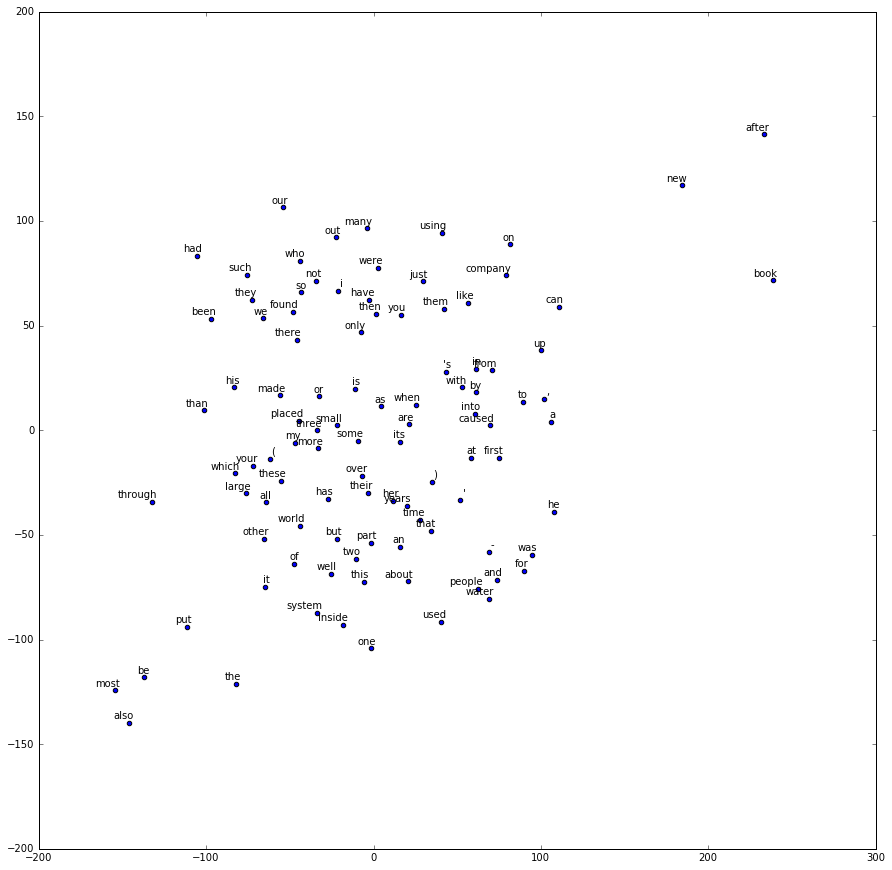

In [307]:
% pylab inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [int2vocab[i] for i in range(num_points)]
plot(two_d_embeddings, words)

In [340]:
del drnn

In [341]:
tf.get_default_session().close()

In [342]:
drnn = RNN_Embed(config)

In [344]:
drnn.restore('checkpoints/drnn_embed_test1-7080.meta')

DataLossError: Unable to open table file checkpoints/drnn_embed_test1-7080.meta: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[Node: save_4/restore_slice = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/restore_slice/tensor_name, save_4/restore_slice/shape_and_slice)]]
Caused by op u'save_4/restore_slice', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/traitlets/config/application.py", line 589, in launch_instance
    app.start()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 440, in start
    ioloop.IOLoop.instance().start()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-342-451ce950a49d>", line 1, in <module>
    drnn = RNN_Embed(config)
  File "<ipython-input-339-1ebcd55ce3fd>", line 28, in __init__
    self.saver = tf.train.Saver(tf.all_variables())
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 784, in __init__
    restore_sequentially=restore_sequentially)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 454, in build
    filename_tensor, vars_to_save, restore_sequentially, reshape)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 212, in _AddRestoreOps
    values = self.restore_op(filename_tensor, vs, preferred_shard)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 127, in restore_op
    preferred_shard=preferred_shard)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 193, in _restore_slice
    preferred_shard, name=name)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 271, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2040, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1087, in __init__
    self._traceback = _extract_stack()


In [89]:
train = {'x': [(s,0,0) for s in yelp_sentences]} # for compatibility later

Helper functions to convert the raw data lines to data and labels

In [56]:
split_delims = [' ',',','.',';',':', '%', '"', '$', '^']
def split(string, delimiters=split_delims, maxsplit=0):
    regexPattern = '|'.join(map(re.escape, delimiters))
    return re.split(regexPattern, string, maxsplit)

def convert_raw_x(line):
    """Convert raw line of semeval data into a useable form
    
    Convert to a triple of (list(raw words), e1_index, e2_index)
    """
    s = line.strip()
    s = s[s.index('"')+1: -(s[::-1].index('"')+1)] # get s between first " and last "
    # we will assume that the first token follow the <e1> , <e2> tags are the entity words.  
    # note this is a big assumption and hopefully phrases will be in subtrees or in heads of the parse trees
    # TODO: this can be addressed by making it a 5-tuple with the endpoints also encoded
    s = split(s)
    for i in range(len(s)):
        # deal with e1's
        if '<e1>' in s[i]:
            e1_index = i
            s[i] = s[i].replace('<e1>', '')
        if '</e1>' in s[i]:
            #e1_index = i
            s[i] = s[i].replace('</e1>', '')
        # eal with e2's
        if '<e2>' in s[i]:
            e2_index = i
            s[i] = s[i].replace('<e2>', '')
        if '</e2>' in s[i]:
            #e2_index = i
            s[i] = s[i].replace('</e2>', '')
        
    # drop extraneous elements from re.split
    # also turn it into a spacy sentence
    s = nlp(u' '.join([ w.lower() for w in s if w is not '' ])) 
    return (s, e1_index, e2_index)
    
label2int = dict() # keep running dictionary of labels
def convert_raw_y(line):
    """Convert raw line of semeval labels into a useable form (ints)"""
    #print "Raw Y: %r" % line[:]
    line = line.strip()
    if line in label2int:
        return label2int[line]
    else:
        label2int[line] = len(label2int.keys())
        return label2int[line]

In [57]:
validation_index = 8000 - 891# len data - len valid - 1 since we start at 0
train = {'x':[], 'y':[]}
valid = {'x':[], 'y':[]}
text = open(training_txt_file, 'r').readlines()
assert len(text) // 4 == 8000
for cursor in range(len(text) // 4): # each 4 lines is a datum
    if cursor < validation_index:
        train['x'].append(convert_raw_x(text[cursor*4]))
        train['y'].append(convert_raw_y(text[cursor*4 + 1]))
        # ignore comments and blanks (+2, +3)
    else:
        valid['x'].append(convert_raw_x(text[cursor*4]))
        valid['y'].append(convert_raw_y(text[cursor*4 + 1]))
        
#print train
#print label2int.values()
assert len(train['y']) == 7109 and len(valid['y']) == 891
assert sorted(label2int.values()) == range(19) # 2 for each 9 asymmetric relations and 1 other
print train['x'][0], train['y'][0]

(the system as described above has its greatest application in an arrayed configuration of antenna elements, 12, 15) 0


In [403]:
train['x'][0][0][0].text

u'the'

In [60]:
train['x'][0][0][0].text

u'Big'

In [127]:
# create the vocab dictionary
counts = collections.Counter()
for sentence, _, _ in train['x']:
    for token in sentence:
        if not token.is_oov and token.text not in [u' ', u'\n\n']:
            counts[token.text] += 1
        
# create the dependency dictionary
dep_counts = collections.Counter()
for sentence, _, _ in train['x']:
    for token in sentence:
        dep_counts[token.dep_] += 1

In [128]:
# get the vocab and the associated unigram probabilities
vocab_limit = 5000
dep_vocab_limit = 45

print counts.most_common()[:20]
vocab = [ x[0] for x in counts.most_common() ][:vocab_limit]
counts_ord = [ x[1] for x in counts.most_common() ][:vocab_limit]
unigram_distribution = list(np.array(counts_ord) / np.sum(counts_ord, dtype=np.float32))
# print sorted(zip(vocab, unigram_distribution), key=lambda x:x[1], reverse=True)[:10]
# print vocab[:10]
print np.sum(unigram_distribution)

# get the depenency vocab and the associated unigram probabilities
# print "+"*80
# print dep_counts.most_common(10)
dep_vocab = [ x[0] for x in dep_counts.most_common() ][:dep_vocab_limit]
dep_counts_ord = [ x[1] for x in dep_counts.most_common() ][:dep_vocab_limit]
dep_unigram_distribution = list(np.array(dep_counts_ord) / np.sum(dep_counts_ord, dtype=np.float32))
print np.sum(dep_unigram_distribution)
# print sorted(zip(dep_vocab, dep_unigram_distribution), key=lambda x:x[1], reverse=True)[:10]

[(u'.', 66441), (u'the', 46847), (u',', 43341), (u'and', 35376), (u'I', 30380), (u'a', 28912), (u'to', 23259), (u'was', 19718), (u'of', 17151), (u'is', 14431), (u'it', 14217), (u'for', 12669), (u'in', 11427), (u'!', 11030), (u'The', 10740), (u'with', 9553), (u'that', 9167), (u'but', 9023), (u'you', 8288), (u"n't", 7388)]
1.0
1.0


In [129]:
print u' ' in vocab

False


In [107]:
def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

In [108]:
print min(unigram_distribution)

9.89845831512e-06


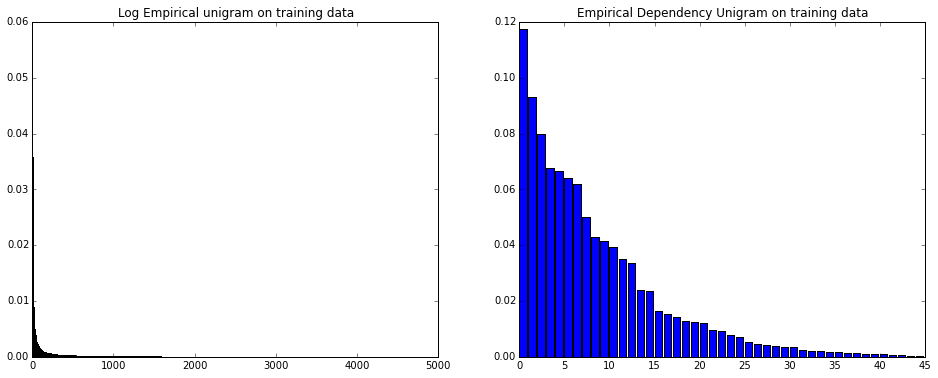

In [109]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(16,6))

#ax0.plot(unigram_distribution[:vocab_limit])
ax0.bar(range(vocab_limit),unigram_distribution)

#ax0.set_xlim([-100,20000])
#ax0.set_yscale('log')
ax0.set_title("Log Empirical unigram on training data")

ax1.bar(range(dep_vocab_limit),dep_unigram_distribution)
#ax1.xlim([-100,20000])
#ax1.yscale('log')
ax1.set_title("Empirical Dependency Unigram on training data")

In [110]:
# create a index lookup dictionary for vocab and dependency vocab
vocab2idx = { v:i for i,v in enumerate(vocab) }
idx2vocab = { i:v for i,v in enumerate(vocab) }

dep_vocab2idx = { v:i for i,v in enumerate(dep_vocab) }
dep_idx2vocab = { i:v for i,v in enumerate(dep_vocab) }

In [111]:
datum = train['x'][0]
print datum
for token in datum[0]:
    print "%r" % [token, token.dep_, token.head]

(Big place so you can always find a seat., 0, 0)
[Big , u'amod', place ]
[place , u'ROOT', place ]
[so , u'mark', find ]
[you , u'nsubj', find ]
[can , u'aux', find ]
[always , u'advmod', find ]
[find , u'advcl', place ]
[a , u'det', seat]
[seat, u'dobj', find ]
[. , u'punct', place ]


In [130]:
# create the skip gram dependency data
train['D'] = []
valid['D'] = []

allowed_vocab = set(vocab)
print u' ' in allowed_vocab
allowed_deps = set(dep_vocab)

for x in train['x']:
    for token in x[0]:
        if token.dep_ != u'ROOT':
            if (token.text in allowed_vocab and token.head.text in allowed_vocab and token.dep_ in allowed_deps
                and not token.is_oov and not token.head.is_oov):
                if token.is_oov: print token
                train['D'].append((token, token.dep_, token.head))
for x in valid['x']:
    for token in x[0]:
        if token.dep_ != u'ROOT':
            if (token.text in allowed_vocab and token.head.text in allowed_vocab and token.dep_ in allowed_deps
                and not token.is_oov and not token.head.is_oov):
                valid['D'].append((token, token.dep_, token.head))
#             for _ in range(num_noisy):
#                 # flip coin to either replace token or dependency
#                 coin_flip = random.uniform(0,1)
#                 if coin_flip > .5:
#                     # replace context word with sample from unigram 
#                     noise_token = vocab[sample_distribution(unigram_distribution)]
#                     train['D-'].append((noise_token, token.dep_, token.head))
#                 else: 
#                     # replace context dependency with sample from unigram 
#                     noise_dependency = dep_vocab[sample_distribution(dep_unigram_distribution)]
#                     train['D-'].append((token, noise_dependency, token.head))
        #else:
        #    print "Found a root: ", (token, token.dep_, token.head)
        

False


In [69]:
print len(train['D'])
print train['D'][0][0].vector.shape
print train['D'][:10]

1058304
(300,)
[(Big , u'amod', place ), (so , u'mark', find ), (you , u'nsubj', find ), (can , u'aux', find ), (always , u'advmod', find ), (find , u'advcl', place ), (a , u'det', seat), (seat, u'dobj', find ), (. , u'punct', place ), (. , u'punct', light)]


In [429]:
nlp.tokenizer(u'the')

the

In [112]:
batch_size = 10
embedding_size = 300
vocab_size = vocab_limit#len(vocab)
dep_vocab_size = dep_vocab_limit #len(dep_vocab)
print vocab_size, dep_vocab_size

5000 45


In [114]:
# create the Levy & Goldberg '14 dependency embeddings tensor
levy_embeddings = np.zeros(shape=[vocab_size, embedding_size], dtype=np.float32)
for word in vocab:
    token = nlp.tokenizer(word)
    levy_embeddings[vocab2idx[word],:] = token.vector

# levy_embeddings = levy_embeddings/np.sqrt(np.sum(levy_embeddings**2, 1, keepdims=True))

[ 0.07932618  0.03119821  0.09438106  0.0708469   0.08708935]
[ 1.] and (array([  14,   44,   47,   54,   74,   75,   85,  172,  190,  309,  349,
        397,  443,  696,  697,  744,  870,  888,  922, 1157, 1210, 1221,
       1366, 1398, 1417, 1469, 1620, 1700, 1733, 1828, 1832, 1857, 1911,
       1940, 1947, 1999, 2003, 2070, 2133, 2161, 2171, 2172, 2186, 2201,
       2210, 2267, 2316, 2474, 2492, 2502, 2514, 2520, 2525, 2600, 2616,
       2626, 2655, 2657, 2662, 2665, 2692, 2719, 2740, 2763, 2795, 2796,
       2813, 2817, 2824, 2876, 2912, 2921, 2944, 2955, 2960, 2991, 3027,
       3030, 3045, 3086, 3089, 3090, 3095, 3123, 3133, 3134, 3140, 3172,
       3202, 3217, 3221, 3238, 3285, 3287, 3315, 3321, 3327, 3329, 3331,
       3347, 3348, 3372, 3430, 3434, 3442, 3444, 3449, 3454, 3458, 3617,
       3624, 3687, 3689, 3690, 3749, 3769, 3790, 3791, 3813, 3825, 3831,
       3836, 3856, 3857, 3861, 3863, 3868, 3873, 3898, 3913, 3919, 3924,
       3928, 3964, 4059, 4062, 4064, 4089, 4108, 41

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.99400000e+03]),
 array([ 0.54156512,  0.58740861,  0.6332521 ,  0.67909558,  0.72493907,
         0.77078256,  0.81662605,  0.86246954,  0.90831302,  0.95415651,  1.        ]),
 <a list of 10 Patch objects>)

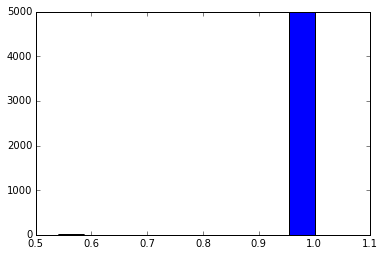

In [115]:
print levy_embeddings[0,:5]
norm = np.sqrt(np.sum(levy_embeddings**2, 1, keepdims=True))
print norm[3], idx2vocab[3],
print np.where(norm == 0)
norm[norm == 0] = 1
# print np.sqrt(np.sum((levy_embeddings / norm)**2, 1))

plt.hist(norm)

In [264]:
assert np.array_equal(levy_embeddings[vocab2idx[u'the']], nlp(u'the')[0].vector)
print levy_embeddings.shape

(5000, 300)


In [118]:
print "%i positive examples" % len(train['D'])
print train['D'][:10]

1058304 positive examples
[(Big , u'amod', place ), (so , u'mark', find ), (you , u'nsubj', find ), (can , u'aux', find ), (always , u'advmod', find ), (find , u'advcl', place ), (a , u'det', seat), (seat, u'dobj', find ), (. , u'punct', place ), (. , u'punct', light)]


In [119]:
# define a batch generator
def generate_batch(batch_size=64, step=0):
    # generate the context, dependency, and true word label for batch size
    start = step*batch_size
    end = start+batch_size if len(train['D']) > start+batch_size else len(train['D'])
    context_batch = np.array(
                            [ vocab2idx[x[0].text] for x in train['D'][start:end] ],
                            dtype=np.int32)
    dep_batch = np.array(
                        [ dep_vocab2idx[x[1]] for x in train['D'][start:end] ],
                        dtype=np.int32)
    labels_batch = np.array(
                            [ vocab2idx[x[2].text] for x in train['D'][start:end] ],
                            dtype=np.int32).reshape([batch_size, 1])
    start += batch_size
    return (context_batch, dep_batch, labels_batch)

In [120]:
print len(set(dep_vocab) ), dep_vocab_size
print len(dep_unigram_distribution), sum(dep_unigram_distribution)

45 45
45 1.0


In [121]:
# dep_norm = tf.sqrt(tf.reduce_sum(tf.square(2*tf.ones([4,4,4])),[1,2], keep_dims=True))
# print dep_norm.get_shape()

In [131]:
### MATRIX VERSION ###

sample_size = 10 # actually is times 2
batch_size = 25

graph = tf.Graph()

with graph.as_default():
    # lookup indices 
    train_contexts = tf.placeholder(tf.int32, shape=[batch_size]) # vector of indices for child nodes
    train_dependencies = tf.placeholder(tf.int32, shape=[batch_size]) # vector of indices for dependency type
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # vector if indices for target words

    ### VARIABLES ###
    # levy word embeddings [ vocab size x embed dim ]
#     word_embeddings = tf.constant(levy_embeddings)
    word_embeddings = tf.Variable(tf.random_uniform(
                                    shape=[vocab_size, embedding_size],
                                    minval=-1., 
                                    maxval=1.0,
                                    seed=0,
                                    dtype=tf.float32))
    # dependency matrix embeddings [ dep vocab x embed dim x embed dim ]
    dep_embeddings = tf.Variable(tf.random_uniform(
                                    shape=[dep_vocab_size, embedding_size, embedding_size],
                                    minval=-1., 
                                    maxval=1.0,
                                    seed=0,
                                    dtype=tf.float32))
    # softmax classifier weights for word prediction [ vocab size, embed dim ]
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocab_size, embedding_size],
                             stddev=1.0 / np.sqrt(embedding_size), dtype=tf.float32))
    # softmax bias [ vocab size ]
    softmax_bias = tf.Variable(tf.zeros([vocab_size], dtype=tf.float32))

    ### MODEL ###

    # First look up the embeddings for both the child context word and the dependency matrix
    # [ batch size x embed dim ]
    word_embed = tf.nn.embedding_lookup(word_embeddings, train_contexts) 
    # [ batch size x 1 x embed dim ]
    word_embed_as_matrices = tf.expand_dims(word_embed,1)

    # [ batch size x embed dim x embed dim ]
    dep_embed = tf.nn.embedding_lookup(dep_embeddings, train_dependencies)

    # then multiply these to get transformed embedding
    # [ batch size x embed dim ]
    node_embed = tf.squeeze(tf.batch_matmul(word_embed_as_matrices, dep_embed))

    sampled_words, _, _ = tf.nn.fixed_unigram_candidate_sampler(true_classes=tf.to_int64(train_labels),
                                          num_true=1,
                                          num_sampled=sample_size,
                                          unique=True,
                                          range_max=vocab_size,
                                          #vocab_file='',
                                          distortion=.75,#1.0,
                                          #num_reserved_ids=0,
                                          unigrams=unigram_distribution,
                                          seed=0,
                                          name=None)
    sampled_deps, _, _ = tf.nn.fixed_unigram_candidate_sampler(true_classes=tf.zeros_like(train_labels, dtype=tf.int64),
                                          num_true=1,
                                          num_sampled=sample_size,
                                          unique=True,
                                          range_max=dep_vocab_size,
                                          #vocab_file='',
                                          distortion=.75,#,
                                          #num_reserved_ids=0,
                                          unigrams=dep_unigram_distribution,
                                          seed=0,
                                          name=None)
    # get the embeddings for each sampled negative
    # repeat for each batch example
    # add an extra dim for the vector*matrix to be matrix*matrix
    sample_word_embed_tiles = tf.expand_dims(tf.tile(
                                              tf.nn.embedding_lookup(word_embeddings, sampled_words),
                                              tf.pack([batch_size, 1])),
                                      1)
    sample_dep_embed_tiles = tf.tile(tf.nn.embedding_lookup(dep_embeddings, sampled_deps),
                               tf.pack([batch_size, 1, 1]))

    # tile the originals also
    word_embed_tiles = tf.tile(word_embed_as_matrices, tf.pack([sample_size, 1, 1]))
    dep_embed_tiles = tf.tile(dep_embed, tf.pack([sample_size, 1, 1]))

    # make sample size x batch size matrix mult for each
    sample_nodes_words = tf.squeeze(tf.batch_matmul(sample_word_embed_tiles, dep_embed_tiles))
    sample_nodes_deps = tf.squeeze(tf.batch_matmul(word_embed_tiles, sample_dep_embed_tiles))
    
    # calculate logits
    true_logits = tf.reduce_sum(
                    tf.matmul(softmax_weights, node_embed, transpose_b=True) 
                    + tf.expand_dims(softmax_bias, 1),
                    0)
    sample_word_logits = tf.reduce_sum(
                            tf.matmul(softmax_weights, sample_nodes_words, transpose_b=True) 
                            + tf.expand_dims(softmax_bias, 1),
                            0)
    sample_dep_logits = tf.reduce_sum(
                            tf.matmul(softmax_weights, sample_nodes_deps, transpose_b=True) 
                            + tf.expand_dims(softmax_bias, 1),
                            0)
    
    # calculate the cross entropy for all three, relative to 1's or 0's respectively
    true_xent = tf.nn.sigmoid_cross_entropy_with_logits(
                     true_logits, tf.ones_like(true_logits),
                     name="true_xent")
    sample_word_xent = tf.nn.sigmoid_cross_entropy_with_logits(
                            sample_word_logits, tf.zeros_like(sample_word_logits),
                            name="sample_word_xent")
    sample_dep_xent = tf.nn.sigmoid_cross_entropy_with_logits(
                            sample_dep_logits, tf.zeros_like(sample_dep_logits),
                            name="sample_dep_xent")
                  

    # loss 
    loss = (tf.reduce_sum(true_xent) 
            + tf.reduce_sum(sample_word_xent) #) / batch_size
            + tf.reduce_sum(sample_dep_xent)) / batch_size
    
    # optimizer
    optimizer = tf.train.AdagradOptimizer(10.)
    
    # we need to perform gradient clipping explicitly
    grads_and_vars = optimizer.compute_gradients(loss, 
                                                 [dep_embeddings, word_embeddings,
                                                  softmax_weights, softmax_bias])
    
    clipped_grads_and_vars = [(tf.clip_by_value(gv[0], -1., 1.), gv[1]) for gv in grads_and_vars]
    
    minimizer = optimizer.apply_gradients(clipped_grads_and_vars)
#     minimizer = optimizer.minimize(loss)
    
    word_norm = tf.sqrt(tf.reduce_sum(tf.square(word_embeddings), 1, keep_dims=True))
    norm_word_embeddings = word_embeddings / word_norm
    dep_norm = tf.sqrt(tf.reduce_sum(tf.square(dep_embeddings), [1, 2], keep_dims=True))
    norm_dep_embeddings = dep_embeddings / dep_norm

In [582]:
# ### VECTOR VERSION ###
# sample_size = 10 # actually is times 2
# batch_size = 25

# graph = tf.Graph()

# with graph.as_default():
#     # lookup indices 
#     train_contexts = tf.placeholder(tf.int32, shape=[batch_size]) # vector of indices for child nodes
#     train_dependencies = tf.placeholder(tf.int32, shape=[batch_size]) # vector of indices for dependency type
#     train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # vector if indices for target words

#     ### VARIABLES ###
#     # levy word embeddings [ vocab size x embed dim ]
#     word_embeddings = tf.constant(levy_embeddings)
# #     word_embeddings = tf.Variable(tf.random_uniform(
# #                                     shape=[vocab_size, embedding_size],
# #                                     minval=-1., 
# #                                     maxval=1.0,
# #                                     seed=0,
# #                                     dtype=tf.float32))
#     # dependency matrix embeddings [ dep vocab x embed dim x embed dim ]
#     dep_embeddings = tf.Variable(tf.random_uniform(
#                                     shape=[dep_vocab_size, embedding_size],
#                                     minval=-1., 
#                                     maxval=1.0,
#                                     seed=0,
#                                     dtype=tf.float32))
#     # softmax classifier weights for word prediction [ vocab size, embed dim ]
#     softmax_weights = tf.Variable(
#         tf.truncated_normal([vocab_size, embedding_size],
#                              stddev=1.0 / np.sqrt(embedding_size), dtype=tf.float32))
#     # softmax bias [ vocab size ]
#     softmax_bias = tf.Variable(tf.zeros([vocab_size], dtype=tf.float32))

#     ### MODEL ###

#     # First look up the embeddings for both the child context word and the dependency matrix
#     # [ batch size x embed dim ]
#     word_embed = tf.nn.embedding_lookup(word_embeddings, train_contexts) 
#     # [ batch size x 1 x embed dim ]
# #     word_embed_as_matrices = tf.expand_dims(word_embed,1)

#     # [ batch size x embed dim x embed dim ]
#     dep_embed = tf.nn.embedding_lookup(dep_embeddings, train_dependencies)

#     # then multiply these to get transformed embedding
#     # [ batch size x embed dim ]
#     node_embed = tf.mul(word_embed, dep_embed)

#     sampled_words, _, _ = tf.nn.fixed_unigram_candidate_sampler(true_classes=tf.to_int64(train_labels),
#                                           num_true=1,
#                                           num_sampled=sample_size,
#                                           unique=True,
#                                           range_max=vocab_size,
#                                           #vocab_file='',
#                                           distortion=.75,#1.0,
#                                           #num_reserved_ids=0,
#                                           unigrams=unigram_distribution,
#                                           seed=0,
#                                           name=None)
#     sampled_deps, _, _ = tf.nn.fixed_unigram_candidate_sampler(true_classes=tf.zeros_like(train_labels, dtype=tf.int64),
#                                           num_true=1,
#                                           num_sampled=sample_size,
#                                           unique=True,
#                                           range_max=dep_vocab_size,
#                                           #vocab_file='',
#                                           distortion=.75,#,
#                                           #num_reserved_ids=0,
#                                           unigrams=dep_unigram_distribution,
#                                           seed=0,
#                                           name=None)
#     # get the embeddings for each sampled negative
#     # repeat for each batch example
#     # add an extra dim for the vector*matrix to be matrix*matrix
#     sample_word_embed_tiles = tf.tile(tf.nn.embedding_lookup(word_embeddings, sampled_words),
#                                       tf.pack([batch_size, 1]))
#     sample_dep_embed_tiles = tf.tile(tf.nn.embedding_lookup(dep_embeddings, sampled_deps),
#                                tf.pack([batch_size, 1]))

#     # tile the originals also
#     word_embed_tiles = tf.tile(word_embed, tf.pack([sample_size, 1]))
#     dep_embed_tiles = tf.tile(dep_embed, tf.pack([sample_size, 1]))

#     # make sample size x batch size matrix mult for each
#     sample_nodes_words = tf.mul(sample_word_embed_tiles, dep_embed_tiles)
#     sample_nodes_deps = tf.mul(word_embed_tiles, sample_dep_embed_tiles)
    
#     # calculate logits
#     true_logits = tf.reduce_sum(
#                     tf.matmul(softmax_weights, node_embed, transpose_b=True) 
#                     + tf.expand_dims(softmax_bias, 1),
#                     0)
#     sample_word_logits = tf.reduce_sum(
#                             tf.matmul(softmax_weights, sample_nodes_words, transpose_b=True) 
#                             + tf.expand_dims(softmax_bias, 1),
#                             0)
#     sample_dep_logits = tf.reduce_sum(
#                             tf.matmul(softmax_weights, sample_nodes_deps, transpose_b=True) 
#                             + tf.expand_dims(softmax_bias, 1),
#                             0)
    
#     # calculate the cross entropy for all three, relative to 1's or 0's respectively
#     true_xent = tf.nn.sigmoid_cross_entropy_with_logits(
#                      true_logits, tf.ones_like(true_logits),
#                      name="true_xent")
#     sample_word_xent = tf.nn.sigmoid_cross_entropy_with_logits(
#                             sample_word_logits, tf.zeros_like(sample_word_logits),
#                             name="sample_word_xent")
#     sample_dep_xent = tf.nn.sigmoid_cross_entropy_with_logits(
#                             sample_dep_logits, tf.zeros_like(sample_dep_logits),
#                             name="sample_dep_xent")
                  

#     # loss 
#     loss = (tf.reduce_sum(true_xent) 
#             + tf.reduce_sum(sample_word_xent) #) / batch_size
#             + tf.reduce_sum(sample_dep_xent)) / batch_size
    
#     # optimizer
#     optimizer = tf.train.AdagradOptimizer(1.)
    
#     # we need to perform gradient clipping explicitly
#     grads_and_vars = optimizer.compute_gradients(loss, 
#                                                  [dep_embeddings,
#                                                   softmax_weights, softmax_bias])
    
#     clipped_grads_and_vars = [(tf.clip_by_norm(gv[0], 1.), gv[1]) for gv in grads_and_vars]
    
#     minimizer = optimizer.apply_gradients(clipped_grads_and_vars)
# #     minimizer = optimizer.minimize(loss)
    
#     word_norm = tf.sqrt(tf.reduce_sum(tf.square(word_embeddings), 1, keep_dims=True))
#     norm_word_embeddings = word_embeddings / word_norm
#     dep_norm = tf.sqrt(tf.reduce_sum(tf.square(dep_embeddings), 1, keep_dims=True))
#     norm_dep_embeddings = dep_embeddings / dep_norm

In [125]:
print len(train['D'])//batch_size
print "Total samples per batch %i + 2x%i = %i" % (batch_size, batch_size*sample_size, (2*sample_size + 1)*batch_size) 

42332
Total samples per batch 25 + 2x250 = 525


Initialized
(0:0:0) Loss at batch 0/5000, epoch: 1 :: 2373.3479
(0:0:6) Loss at batch 10/5000, epoch: 1 :: 39683241012.8498
(0:0:12) Loss at batch 20/5000, epoch: 1 :: 45918688283.6832
(0:0:18) Loss at batch 30/5000, epoch: 1 :: 39662552479.1403
(0:0:24) Loss at batch 40/5000, epoch: 1 :: 33388917418.2768
(0:0:30) Loss at batch 50/5000, epoch: 1 :: 30461829126.3794
(0:0:36) Loss at batch 60/5000, epoch: 1 :: 27323588256.6123
(0:0:42) Loss at batch 70/5000, epoch: 1 :: 25447121033.9908
(0:0:48) Loss at batch 80/5000, epoch: 1 :: 23587344182.5845
(0:0:54) Loss at batch 90/5000, epoch: 1 :: 22538952068.9818
(0:0:59) Loss at batch 100/5000, epoch: 1 :: 21605737361.1619
(0:1:5) Loss at batch 110/5000, epoch: 1 :: 20385619793.3455
(0:1:11) Loss at batch 120/5000, epoch: 1 :: 19508865625.4326
(0:1:16) Loss at batch 130/5000, epoch: 1 :: 18605500604.1324
(0:1:22) Loss at batch 140/5000, epoch: 1 :: 17760182558.4493
(0:1:28) Loss at batch 150/5000, epoch: 1 :: 17003051251.7440
(0:1:33) Loss at 

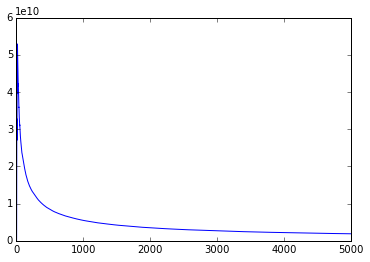

In [136]:
from time import time
num_epochs = 1
with tf.Session(graph=graph) as session:
    # initialize the graph
    tf.initialize_all_variables().run()
    print('Initialized')                        

#     while start < len(train['x']):
    step = 0
    losses = [0]
    start = time()
    num_batches = 5000 #len(train['D'])//batch_size
    for epoch in range(num_epochs):
        for step in range(num_batches):
            train_context_batch, train_dep_batch, train_labels_batch = generate_batch(batch_size=batch_size, step=step)
            feed_dict = {train_contexts : train_context_batch,
                         train_dependencies : train_dep_batch, 
                         train_labels : train_labels_batch}

    #         print "max softmax W, b values: %g %g"%(tf.reduce_max(tf.abs(softmax_weights)).eval(),tf.reduce_max(tf.abs(softmax_bias)).eval())
    #         print "max word, dep embed values: %g %g"%(tf.reduce_max(tf.abs(word_embeddings)).eval(),tf.reduce_max(tf.abs(dep_embeddings)).eval())

    #         print setp
            o, l = session.run([minimizer, loss], feed_dict=feed_dict)
            losses.append((step*losses[step] + l) /(step+1))
            if step % 10 == 0:
                m,s = divmod(time()-start, 60)
                h,m = divmod(m, 60)
                print ("(%i:%i:%i) Loss at batch %i/%i, epoch: %i :: %0.4f" 
                       % ( h,m,s, step, num_batches, epoch+1, losses[-1]))


    new_norm_words = norm_word_embeddings.eval()
    new_norm_deps = norm_dep_embeddings.eval()

plt.plot(range(len(losses)),losses)
#print zip(word_embeddings.eval()[vocab2idx[u'the'],:], levy_embeddings[vocab2idx[u'the']])

In [586]:
big_norm_words = norm_words
big_norm_deps = norm_deps

In [138]:
norm_deps = new_norm_deps
norm_words = new_norm_words

In [139]:
norm_words[np.isnan(norm_words)] = 0
print norm_words[np.where(norm_words == 0)].shape, 18069*300

(0,) 5420700


In [228]:
session.close()

In [229]:
### DEBUG ###
session = tf.InteractiveSession(graph=graph)
# initialize the graph
tf.initialize_all_variables().run()
print('Initialized')                        
step = 0
train_context_batch, train_dep_batch, train_labels_batch = generate_batch(batch_size=batch_size, step=step)
# print "%r" % train_context_batch
# print "%r" % train_dep_batch
# print "%r" % train_labels_batch
feed_dict = {train_contexts : train_context_batch,
             train_dependencies : train_dep_batch, 
             train_labels : train_labels_batch}
# so far between  and sample_dep_embed_tiles
session.run([sample_word_logits], feed_dict=feed_dict)
print np.any(np.isnan(sample_word_logits.eval(feed_dict=feed_dict)))
#     o, l = session.run([optimizer, loss], feed_dict=feed_dict)

Initialized
False


In [144]:
% time
num_points = 100

tsne = TSNE(perplexity=5, n_components=2, 
            init='pca', 
            n_iter=50000, random_state=0)
# two_d_embeddings = tsne.fit_transform(norm_words[1:num_points+1, :])
two_d_embeddings = tsne.fit_transform(norm_words[:num_points, :])


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


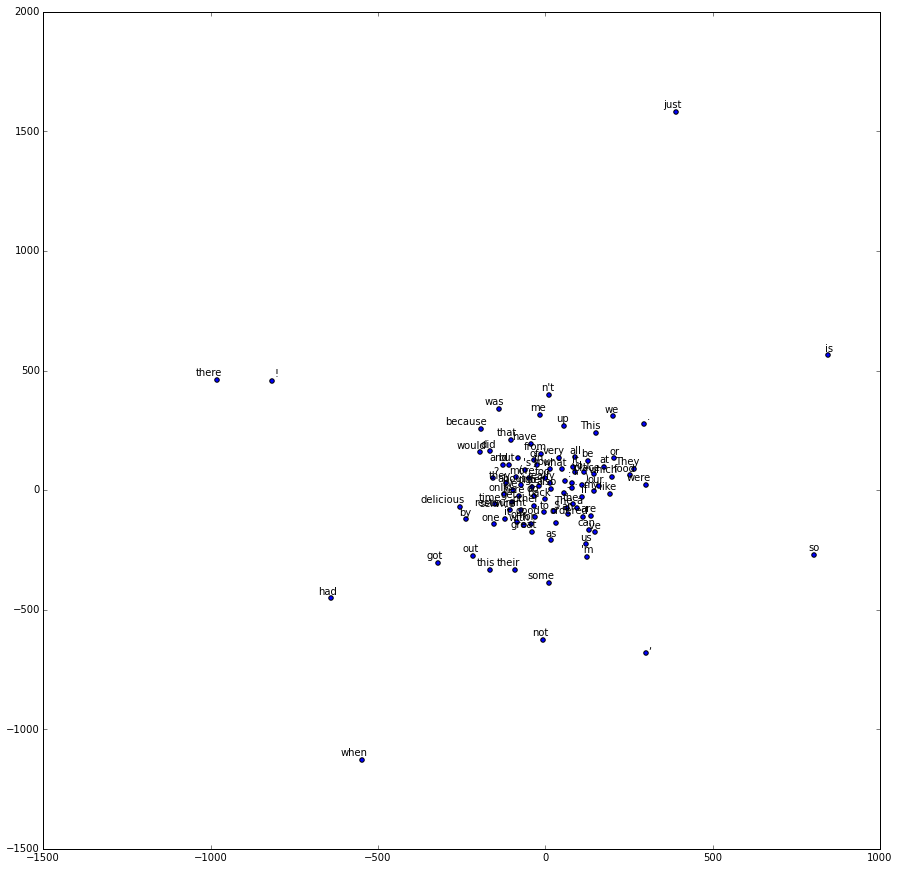

In [145]:
% pylab inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [idx2vocab[i] for i in range(num_points)]
plot(two_d_embeddings, words)

In [125]:
closest_to = sorted(zip(list(norm_words), vocab), key=lambda x:np.dot(x[0], norm_words[vocab2idx['one']]))


In [126]:
print [x[1] for x in closest_to[:10]]

[u'on', u'with', u'like', u'after', u'political', u'new', u'about', u'from', u'behind', u'toward']


In [163]:
% time
num_points = 10

tsne = TSNE(perplexity=5, n_components=2, 
            init='pca', n_iter=5000,
            verbose=1,
            learning_rate=100,
            random_state=0)
two_d_embeddings = tsne.fit_transform(norm_deps.reshape(dep_vocab_size, embedding_size**2)[:num_points])

# assert np.all(two_ud_embeddings == two_d_embeddings)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 0.166958
[t-SNE] Error after 100 iterations with early exaggeration: 14.308179
[t-SNE] Error after 329 iterations: 1.077764


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


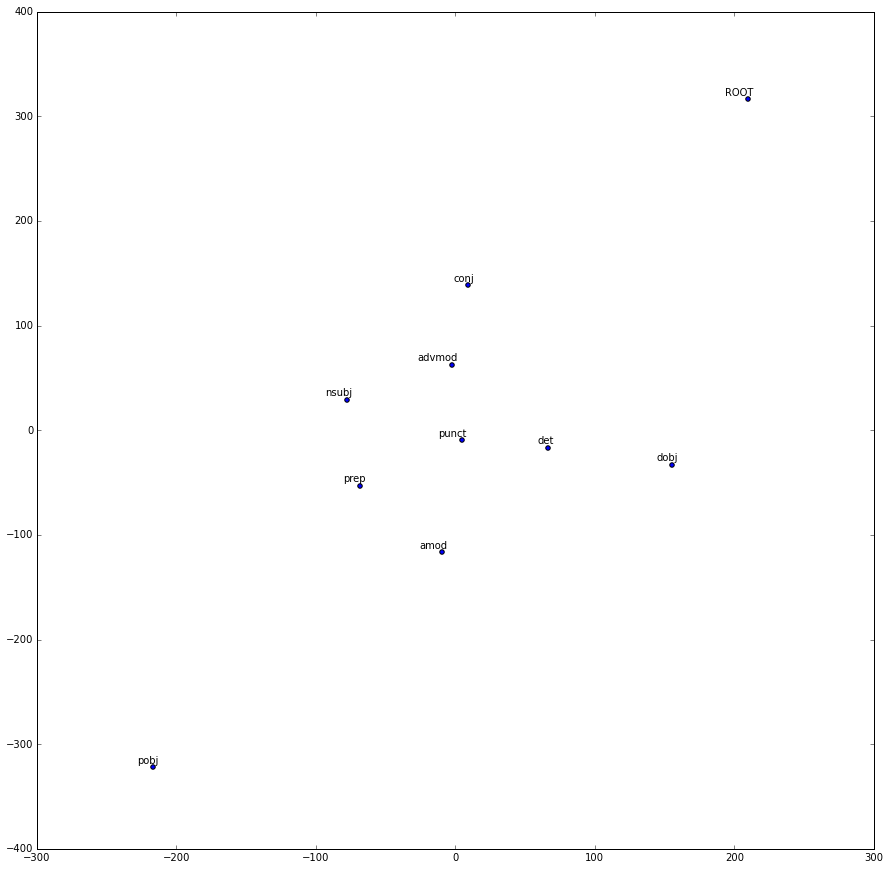

In [164]:
% pylab inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
#   for i, label in enumerate(labels):
#     x, y = two_ud_embeddings[i,:]
#     pylab.scatter(x, y)
#     pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')
  pylab.show()

deps = dep_vocab
plot(two_d_embeddings, deps[:num_points])

In [590]:
print norm_deps.shape

(45, 300)


In [434]:
norm_words = levy_embeddings

In [154]:
# check out validations
k = 5
num_valid = len(valid['D'])
true = np.empty([num_valid, embedding_size])
project = np.empty([num_valid, embedding_size])
rands = np.empty([num_valid, embedding_size])
valid_labels = [] 
valid_proj_labels = []
valid_rands_labels = []
for i, triple in enumerate(valid['D'][:100]):
    tail, dep, head = triple
    valid_labels.append(head.text)
    valid_proj_labels.append("%s(%s)=%s" % (dep, tail.text, head.text))
    true[i] = norm_words[vocab2idx[head.text]]
#     project[i] = norm_words[vocab2idx[tail.text],:]* norm_deps[dep_vocab2idx[dep],:]
    project[i] = np.dot(norm_words[vocab2idx[tail.text],:], norm_deps[dep_vocab2idx[dep],:,:])
#     project[i] /= np.linalg.norm(project[i])
    if np.any(np.isnan(project[i])):
        print norm_words[vocab2idx[tail.text]], tail.text, dep
    rand_context_word = sample_distribution(unigram_distribution)
#     print rand_context_word
    rands[i] = np.dot(norm_words[rand_context_word], norm_deps[dep_vocab2idx[dep]])
#     rands[i] = norm_words[rand_context_word]* norm_deps[dep_vocab2idx[dep]]
#     rands[i] /= np.linalg.norm(rands[i])
    valid_rands_labels.append("%s(%s)=%s" % (dep, idx2vocab[rand_context_word], head.text))
    
    # rank nearest neighbors for projection and random
    print str(i)+80*"-"
    sims = sorted([(j, np.dot(project[i], norm_words[j])) for j in range(vocab_size)], key=lambda x:x[1], reverse=True)
    proj_close = [ idx2vocab[s[0]] for s in sims ]
    print "%i closest to %s(%s)=%s: %r" % (k, dep, tail.text, head.text, proj_close[:k])
    sims = sorted([(j, np.dot(rands[i], norm_words[j])) for j in range(vocab_size)], key=lambda x:x[1], reverse=True)
    rands_close = [ idx2vocab[s[0]] for s in sims ]
    print "%i closest to %s(%s)=%s: %r" % (k, dep, idx2vocab[rand_context_word], head.text, rands_close[:k])
    sims = sorted([(j, np.dot(true[i], norm_words[j])) for j in range(vocab_size)], key=lambda x:x[1], reverse=True)
    trues_close = [ idx2vocab[s[0]] for s in sims ]
    print "%i closest to %s: %r" % (k, head.text, trues_close[:k])
    print np.sqrt(np.sum(norm_words[vocab2idx[tail.text]]**2)), np.sqrt(np.sum(project[i]**2)), np.sqrt(np.sum(true[i]**2))
print true.shape, project.shape, rands.shape
# print np.any(np.isnan(project))

0--------------------------------------------------------------------------------
5 closest to mark(as)=moves: [u'him', u'japanese', u'dimly', u'worth', u'UWS']
5 closest to mark(serious)=moves: [u'patrons', u'tooth', u'wall', u'disgusting', u'desserts']
5 closest to moves: [u'moves', u'smelled', u'Thanks', u'exception', u'Lots']
1.0 0.0838994693273 0.999999883299
1--------------------------------------------------------------------------------
5 closest to nsubj(it)=moves: [u'Reasonably', u'25', u'wearing', u'Glad', u'aloo']
5 closest to nsubj(the)=moves: [u'jelly', u'marks', u'cousins', u'picky', u'the']
5 closest to moves: [u'moves', u'smelled', u'Thanks', u'exception', u'Lots']
1.0 0.0568282005927 0.999999883299
2--------------------------------------------------------------------------------
5 closest to advcl(moves)=cuts: [u'win', u'Besides', u'vegan', u'throughout', u'justice']
5 closest to advcl(noisy)=cuts: [u'Vegetarian', u'quail', u'suggestion', u'Amazing', u'pork']
5 closes

In [550]:
for i in range(num_valid):
    print np.dot(true[i], project[i]), np.dot(true[i], rands[i])

-0.00114159403569 -0.00118730560444
0.0299211402866 -0.00301318616419
0.00943380460081 -0.00447645709254
0.00399942664039 0.00702799695212
0.00262715614633 0.00110639144684
0.000369392629978 -0.00164681444602
-0.00416608112843 0.000402633535087
-0.000761986407803 -0.00455051185902
0.000580404077891 -0.00206671937683
0.00992381511786 -0.000115764802145
0.00993972447048 -0.00241966606154
0.00369890581832 -0.00123189785308
-0.00377757697129 -0.00387673089878
-0.000332410882668 0.00967063228213
-0.00127451062207 -0.00127451062207
-0.00165490461996 -0.00793130432865
0.000853422002239 -0.00465842345542
0.0127465124475 0.00162022467708
-0.00458474919969 -0.00440066954374
-0.00311215529157 -0.00159281073866
-0.00877157812918 -0.00228698223678
-0.0253638299513 -0.0172257751823
-0.0151185294741 -0.0192022415844
-0.00879292089819 -0.0020564392386
-0.0170337173916 0.0110845677348
-0.00655135148439 -0.00616762218222
-0.0128711422761 -0.00533182833922
-0.0171553441461 -0.0177943289091
-0.01560940694

In [155]:
avg_true_sim = sum([np.dot(true[i], project[i]) for i in range(num_valid)]) /float(num_valid)
avg_fake_sim = sum([np.dot(true[i], rands[i]) for i in range(num_valid)]) /float(num_valid)
# [(np.dot(true[i], project[i]), np.dot(true[i], rands[i])) for i in range(num_valid)]
print "Average valid and random similairities %.3f :: %.3f" % (avg_true_sim, avg_fake_sim)

Average valid and random similairities -0.000 :: -0.000


In [156]:
% time
num_points = 100

tsne = TSNE(perplexity=4, n_components=2, 
            init='pca', n_iter=5000,
            verbose=1,
            learning_rate=100,
            random_state=0)

# good_embeddings = tsne.fit_transform(true[:num_points])
# proj_embeddings = tsne.fit_transform(project[:num_points])
# rands_embeddings = tsne.fit_transform(rands[:num_points])

all_in_one = tsne.fit_transform(np.vstack((true[:num_points],
                                          project[:num_points],
                                          rands[:num_points])))

good_embeddings, proj_embeddings, rands_embedding = np.vsplit(all_in_one, 3)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 15.912843
[t-SNE] Error after 215 iterations: 1.094235


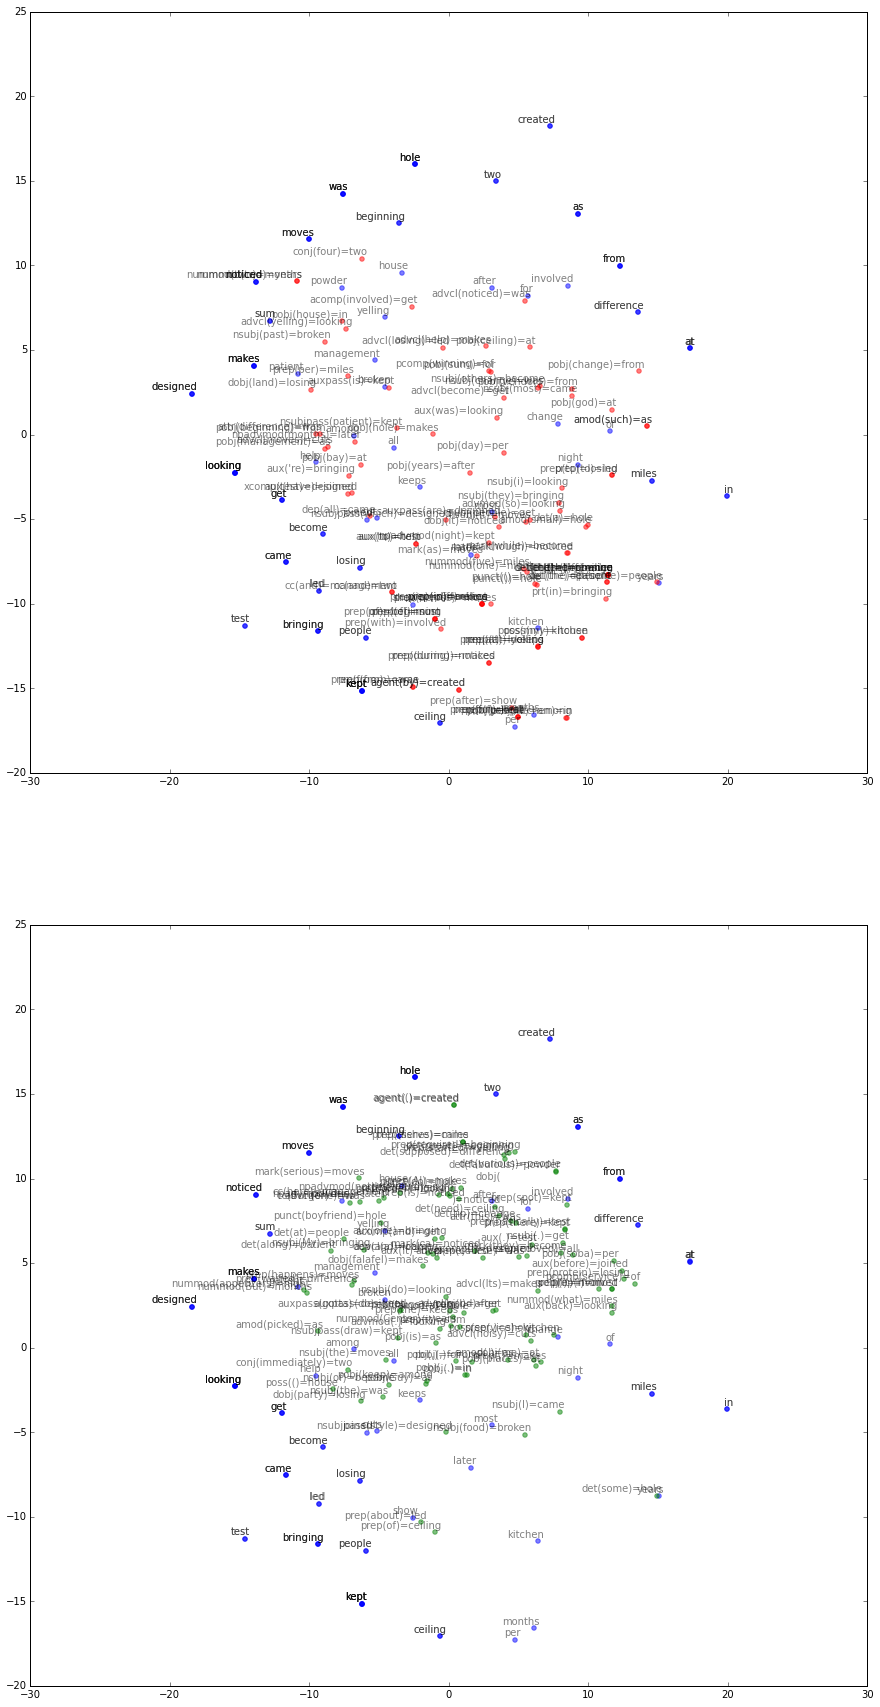

In [159]:
# assert np.all(two_ud_embeddings == two_d_embeddings)

# def plot(embeddings, labels):
# assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
fig, (ax0, ax1) = plt.subplots(2, 1,figsize=(15,30))  # in inches
for i, label in enumerate(valid_labels[:num_points]):
    x, y = good_embeddings[i,:]
    #     print type(x),y
    ax0.scatter(x, y, color='b', alpha=.5, label="True")
    ax0.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom', alpha=.5)
    x1, y1 = proj_embeddings[i,:]
    ax0.scatter(x1, y1, color='r', alpha=.5, label="Projection")
    ax0.annotate(valid_proj_labels[i], xy=(x1, y1), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom', alpha=.5)
    #     ax0.plot([x,x1], [y,y1], 'k--', alpha=.5)

    #     print type(x),y
    ax1.scatter(x, y, color='b', alpha=.5, label="True")
    ax1.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom', alpha=.5)
    x2, y2 = rands_embedding[i,:]
    ax1.scatter(x2, y2, color='g', alpha=.5, label="Random")
    ax1.annotate(valid_rands_labels[i], xy=(x2, y2), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom', alpha=.5)
#     ax1.plot([x,x2], [y,y2], 'k--', alpha=.5)

#   for i, label in enumerate(labels):
#     x1, y1 = rands_embeddings[i,:]
#     ax.scatter(x1, y1, color='r', alpha=.5)
#     ax.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                    ha='right', va='bottom')

# plot(good_embeddings, valid_labels[:num_points])

In [323]:
train_vocab = set([token for sentence in train_x for token in sentence])
valid_vocab = set([token for sentence in valid_x for token in sentence])

In [325]:
jaccard = len(train_vocab.intersection(valid_vocab)) / float(len(train_vocab.union(valid_vocab)))

In [327]:
print(jaccard)

0.131960521506
